In [2]:
import sys 
import os
import cobra
import cplex 
import libsbml
import copy
from pathlib import Path
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import path 
import pandas as pd
import numpy as np
from scipy.stats import zscore
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu
import multiprocessing
from itertools import combinations, product
from multiprocessing import Pool
from sklearn.decomposition import PCA
import mplcursors
import openpyxl as px


from sklearn.linear_model  import LinearRegression

#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src/")

import model_initialize as mi
import model_manipulation as mm


#Set solver to gurobi
config = cobra.Configuration()
config.solver = 'glpk'

#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6


#Add trans reactions to trans_model
mi.add_trans_reactions(trans_model)




Pipeline breakdown:

Load the generated bivariate sensitivity ANalysis first.

Initialize the dataframe by opening up each sheet of the dataframe, retrieving the columns and rows of interest (i.e., EX_PhotonVis(e) and EX_nh4(e)) then afterwards mapping the model to specific reactions. Add the independent variables in two columns.

Generate each respective variable as a long format dataframe


In [3]:

def generate_dataframe_from_excel(excel_file, variable1, variable2, reactions_list):
    # Load the Excel file
    wb = px.load_workbook(excel_file, read_only=True, data_only=True)

    # Get the sheet names; sheet names were taken from the original parameters so I'll use it.
    sheet_names = wb.sheetnames 

    # List to store dataframes for each sheet
    dataframes_list = []
    
    # Loop through each sheet and create a dataframe
    for sheet_name in sheet_names:
        # Load the worksheet
        ws = wb[sheet_name]
        data = ws.values

        # Convert the sheet data to a dataframe
        columns = next(data)  # Assuming the first row contains column headers
        sheet_df = pd.DataFrame(data, columns=columns)
        sheet_df = sheet_df.set_index(sheet_df.iloc[:, 0].name)
        
        # Create a list of dictionaries for each row in the sheet
        rows_list = []
        for rxn in reactions_list:
            try:
                row_values = sheet_df.loc[rxn]
                for idx, val in row_values.items():
                    row_dict = {
                        'var1': variable1, # PPfd 
                        'x_axis': float(sheet_name),
                        'var2': variable2, # EX_nh4
                        'y_axis': float(idx),
                        'reaction_id': rxn,
                        'reaction_fluxes': val,
                    }
                    rows_list.append(row_dict)
            except KeyError: #Proceed if reaction not in DF (happens with different iterations of model constraints)
                continue
        # Convert the list of dictionaries to a DataFrame for the current sheet
        dataframe_for_adding = pd.DataFrame(rows_list)
        dataframes_list.append(dataframe_for_adding)
        
    # Concatenate all DataFrames from different sheets into the final DataFrame
    rxn_df = pd.concat(dataframes_list, ignore_index=True)

    return rxn_df


def generate_meshgrid(df, var1, var2, values, reaction):
    # Filter dataset based on reaction
    df_filtered = df[df['reaction_id'] == reaction]

    X_unique = np.sort(df_filtered[var1].unique())
    Y_unique = np.sort(df_filtered[var2].unique())
    X, Y = np.meshgrid(X_unique, Y_unique)

    Z = df_filtered.pivot_table(index=var1, columns=var2, values=values).values

    return X, Y, Z

reactions_of_interest = [rxns.id for rxns in trans_model.reactions]

path1= './flux_results/N_benchmark/FBA/Trans/N-benchmark-mature-trans-leaf.xls-20230803-05:17.xlsx'
path2 = './flux_results/CO2_benchmark/FBA/Trans/CO2|PPFD-benchmark-TR.xls-20230807-17:49.xlsx'
path3 = './flux_results/CO2_NH3_Benchmark/FBA/Trans/N|CO2-TR-250PPFD-20230803-08:09.xlsx'
path4 = './flux_results/CO2_NH3_Benchmark/FBA/Trans/N|CO2-TR-750PPFD-20230803-08:13.xlsx'
path5 = './flux_results/CO2_NH3_Benchmark/FBA/Trans/N|CO2-TR-1500PPFD-20230803-08:18.xlsx'
df1 = generate_dataframe_from_excel(path1, 'PPFD', 'NH4', reactions_of_interest)
df2 = generate_dataframe_from_excel(path2, 'PPFD', 'CO2', reactions_of_interest)
df3 = generate_dataframe_from_excel(path3, 'NH4', 'CO2', reactions_of_interest)
df4 = generate_dataframe_from_excel(path4, 'NH4', 'CO2', reactions_of_interest)
df5 = generate_dataframe_from_excel(path5, 'NH4', 'CO2', reactions_of_interest)
        

df_list= [df1,df2, df3, df4, df5]



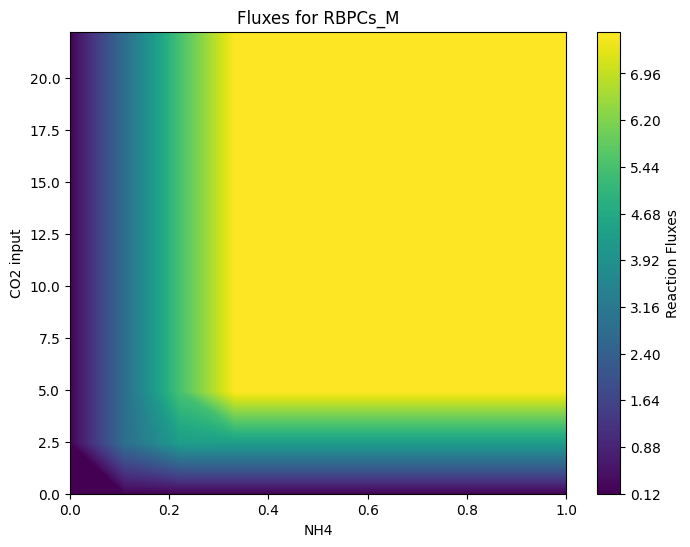

In [4]:


X,Y,Z = generate_meshgrid(df3, 'x_axis', 'y_axis', 'reaction_fluxes', 'RBPCs_M') 


# Initialize plot objects

# Initialize plot objects
plt.figure(figsize=(8, 6))
plt.xlabel('NH4')
plt.ylabel('CO2 input')
plt.title('Fluxes for RBPCs_M')

# Generate a contour plot
contour_plot = plt.contourf(X, Y, Z, levels=200, cmap='viridis')
plt.colorbar(contour_plot, label='Reaction Fluxes')

plt.show()

saved plot to ./plots/sensitivity_analysis/Sensitivity_analysis_large_format_shortened.png


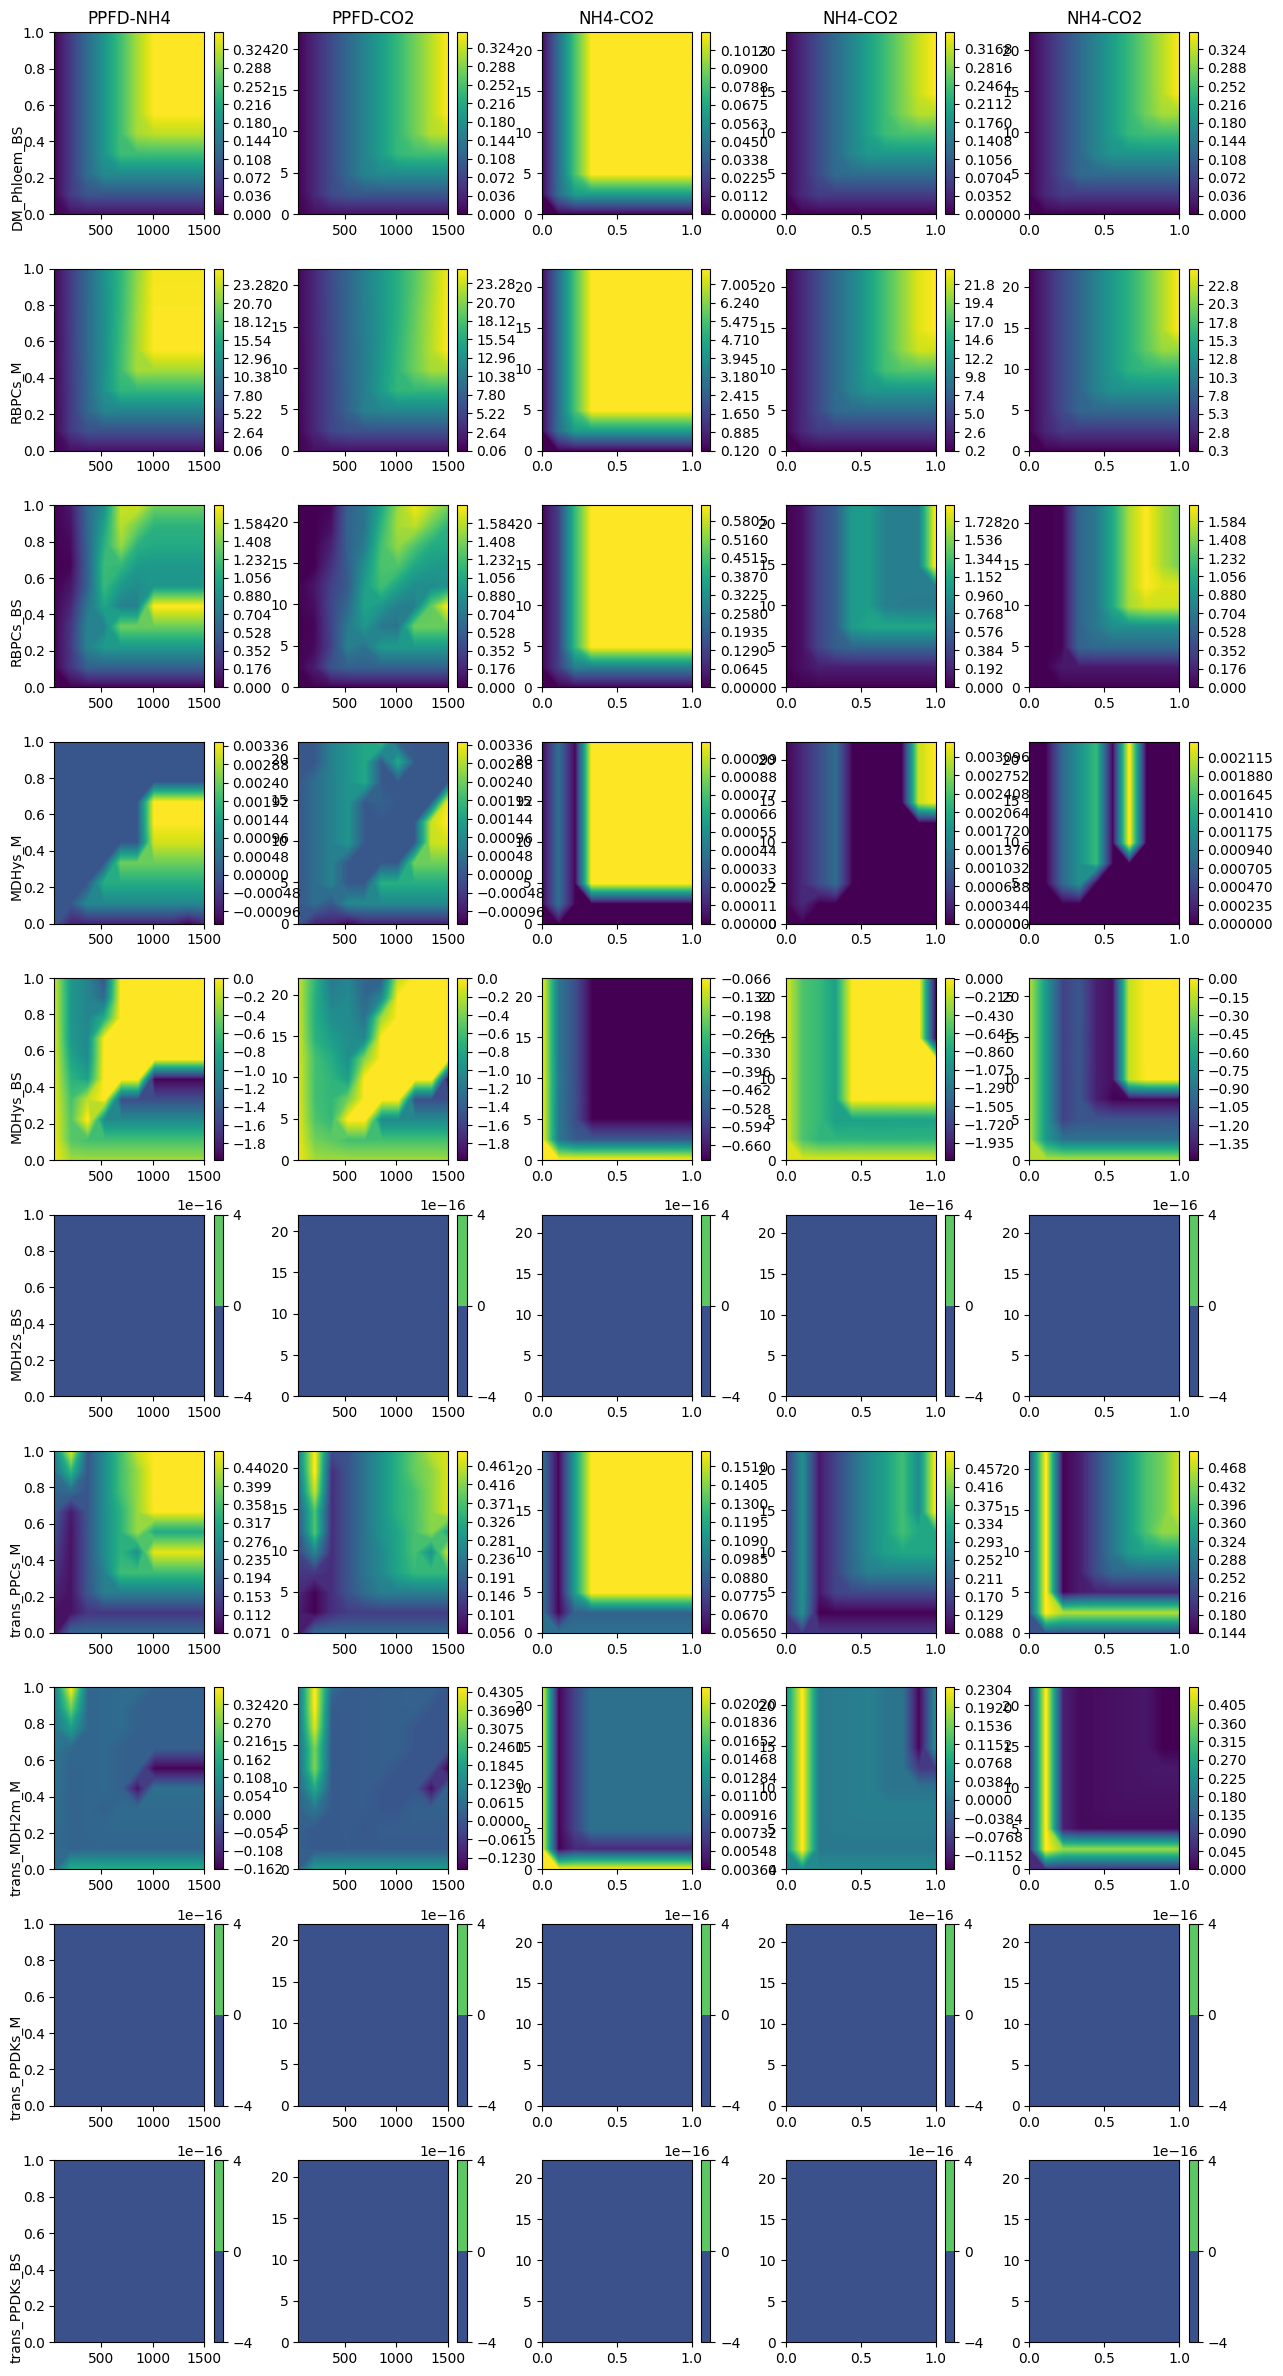

In [7]:
from itertools import cycle

#Create a custom plot showing reactions of interest, showing the ff.
# reactions_of_interest =  ['ENOs_M','ENOc_M','CSm_M','MDHm_M','GLUSys_M','EX_h(e)','GLYDHDm_M','GLYDHDm_BS', 'MALCITtm_M','CCEFs_M','PSIMR_M','PSIINC_M','PPDKs_M','dhap_pd','PPDKc_M', 'PPCc_M', 'trans_PPCs_M','trans_MDH2m_M','trans_hco3ec_M', 'MDH2s_M', 'MDH2s_BS', 'RBPCs_M', 'RBPCs_BS']
reactions_of_interest1=['DM_Phloem_BS','RBPCs_M','RBPCs_BS','MDHys_M','MDHys_BS', 'MDHs_M','MDHm_M', 'trans_PPCs_M', 'trans_MDH2m_M', 'trans_PPDKs_M','trans_PPDKs_BS']
reactions_of_interest2=['DM_Phloem_BS','RBPCs_M','RBPCs_BS','MDHys_M','MDHys_BS','MDH2s_BS', 'trans_PPCs_M', 'trans_MDH2m_M', 'trans_PPDKs_M','trans_PPDKs_BS']

def generate_meshgrid(df, var1, var2, values, reaction):
    # Filter dataset based on reaction
    df_filtered = df[df['reaction_id'] == reaction]

    X_unique = np.sort(df_filtered[var1].unique())
    Y_unique = np.sort(df_filtered[var2].unique())
    X, Y = np.meshgrid(X_unique, Y_unique)

    Z = df_filtered.pivot_table(index=var1, columns=var2, values=values).values

    return X, Y, Z
def generate_sensitivity_analysis_plots(dfs_list, reaction_list, plot_scale=3, directory='./plots/sensitivity_analysis/', filename=''):
    # Cols correspond to the treatments used while rows correspond to reactions of interest.
    
    
    ncols = len(dfs_list)
    nrows = len(reaction_list)
    figsize= (plot_scale*ncols, plot_scale*nrows) 
    # Figure and subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
 
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)



    for i in range(ncols):
        # Get dataframe
        df = df_list[i]
        var1 = df['var1'].unique()[0]
        var2 = df['var2'].unique()[0]

        for j in range(nrows):
            rxn = reaction_list[j]
            x, y, z = generate_meshgrid(df, 'x_axis', 'y_axis', 'reaction_fluxes', rxn)
            # Initialize plot objects
            ax = axes[j, i]  # Fixed axes order (j, i) instead of (i, j)

            # Remove redundant labels from subplots
            if j != 0:
                ax.set_ylabel('')
            if i != 0:
                ax.set_xlabel('')
            if i != 0 and j != 0:
                ax.set_title('')

            # If i==0, add the 'rxn' label to the left
            if i == 0:
                # row_label = f'{rxn}'
                ax.set_ylabel(rxn, rotation=90, ha='right', va='center')

            # If j==0, add the label composed of {var1}{var2} to the top
            if j == 0:
                col_label = f'{var1}-{var2}'
                ax.set_title(col_label)
 
 

            # Generate a contour plot
            contour_plot = ax.contourf(x, y, z, levels=500, cmap='viridis')
            plt.colorbar(contour_plot, ax=ax)  # Added ax=ax here


    # Save plot to dir

    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    filename=f'{filename}.png'
        
    plot_path = os.path.join(directory, filename)
    fig.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f'saved plot to {directory}{filename}')

    plt.show()

    

    
generate_sensitivity_analysis_plots(df_list, reactions_of_interest2, filename='Sensitivity_analysis_large_format_shortened')
    
